In [27]:
import numpy as np
from amazonzero.board import Board
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
board = Board(4, 2)

In [29]:
board.matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 2.]])

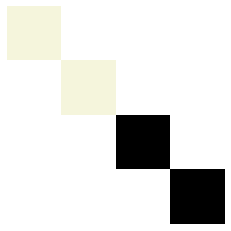

In [31]:
board.plot_board()

In [18]:
plt.show();